In [3]:
!pip install landlab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 65.2 MB/s eta 0:00:00


In [4]:
import copy

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from landlab import HexModelGrid
from landlab.components import ErosionDeposition, FlowAccumulator
from landlab.plot import imshow_grid

In [5]:
print(ErosionDeposition.__doc__)

Erosion-Deposition model in the style of Davy and Lague (2009).

    Erosion-Deposition model in the style of Davy and Lague (2009). It uses a
    mass balance approach across the total sediment mass both in the bed and
    in transport coupled with explicit representation of the sediment
    transport lengthscale (the "xi-q" model) to derive a range of erosional
    and depositional responses in river channels.

    This implementation is close to the Davy & Lague scheme, with a few
    deviations:

    * A fraction of the eroded sediment is permitted to enter the wash load,
      and lost to the mass balance (``F_f``).
    * Here an incision threshold ``omega`` is permitted, where it was not by Davy &
      Lague. It is implemented with an exponentially smoothed form to prevent
      discontinuities in the parameter space. See the
      :py:class:`~landlab.components.StreamPowerSmoothThresholdEroder`
      for more documentation.
    * This component uses an "effective" settling velo

In [6]:
print(ErosionDeposition.__init__.__doc__)

Initialize the ErosionDeposition model.

        Parameters
        ----------
        grid : ModelGrid
            Landlab ModelGrid object
        K : str or array_like, optional
            Erodibility for substrate (units vary).
        v_s : str or array_like, optional
            Effective settling velocity for chosen grain size metric [L/T].
        m_sp : float, optional
            Discharge exponent (units vary)
        n_sp : float, optional
            Slope exponent (units vary)
        sp_crit : str or array_like, optional
            Critical stream power to erode substrate [E/(TL^2)]
        F_f : float, optional
            Fraction of eroded material that turns into "fines" that do not
            contribute to (coarse) sediment load. Defaults to zero.
        discharge_field : str or array_like, optional
            Discharge [L^2/T]. The default is to use the grid field
            'surface_water__discharge', which is simply drainage area
            multiplied by t

In [7]:
# Parameters
nrows = 41
ncols = 41
dx = 100.0
K = 0.0001  # erodibility coefficient, 1/yr
m_sp = 0.5  # exponent on drainage area or discharge, -
n_sp = 1.0  # exponent on slope, -
sp_crit = 0.0  # erosion threshold
v_s = 100.0  # settling velocity parameter (dimensionless if drainage area is used instead of discharge)
F_f = 0.5  # fraction of fines generated during bed erosion
initial_elevation = (
    200.0  # starting elevation of an "uplifted block" (rapid baselevel drop), m
)

run_duration = 120000.0  # duration of run, yr
dt = 100.0  # time-step duration, yr
plot_every = 40000.0  # time interval for plotting, yr

# Derived parameters
nsteps = int(run_duration / dt)
next_plot = plot_every

# set up colormap
cmap = copy.copy(mpl.colormaps["pink"])

In [8]:
mg = HexModelGrid(
    (nrows, ncols), spacing=dx, node_layout="rect", orientation="vertical"
)
z = mg.add_zeros("topographic__elevation", at="node")
# add some roughness, as this lets "natural" channel planforms arise
np.random.seed(0)
initial_roughness = np.random.rand(z.size)
z[:] += initial_roughness
z[mg.core_nodes] += initial_elevation
z[mg.boundary_nodes] = 0.0

# close off boundaries on 3 sides
is_closed_boundary = np.logical_and(
    mg.status_at_node != mg.BC_NODE_IS_CORE,
    mg.x_of_node < (np.amax(mg.x_of_node) - 0.5 * dx),
)
mg.status_at_node[is_closed_boundary] = mg.BC_NODE_IS_CLOSED

In [9]:
fr = FlowAccumulator(mg, depression_finder="DepressionFinderAndRouter")
ed = ErosionDeposition(
    mg,
    K=K,
    m_sp=m_sp,
    n_sp=n_sp,
    sp_crit=sp_crit,
    v_s=v_s,
    F_f=F_f,
    solver="adaptive",  # use the adaptive time stepper, which is slightly faster
)

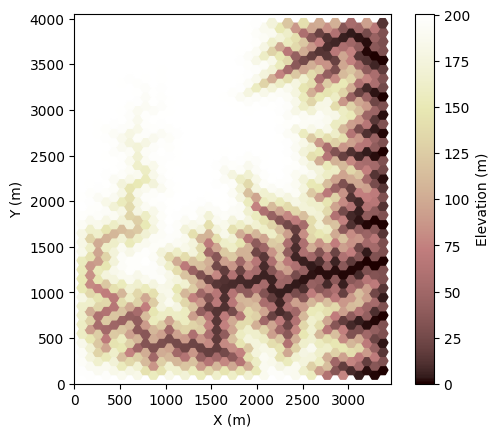

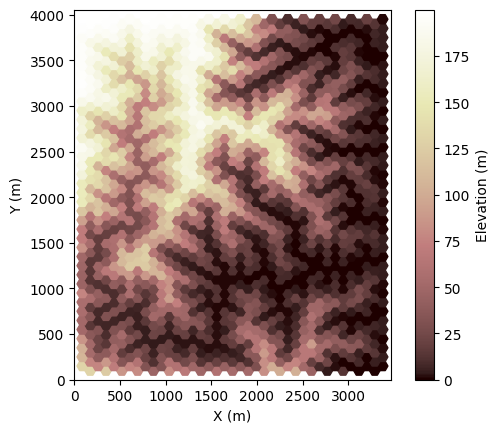

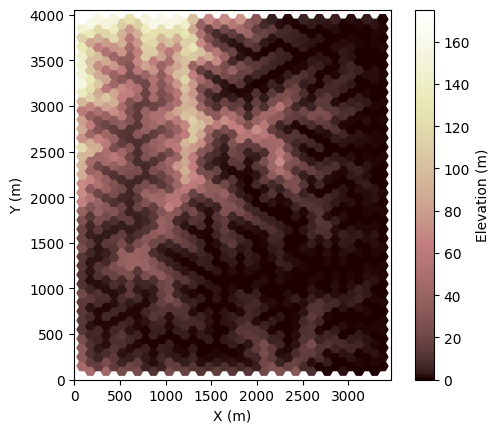

In [10]:
for i in range(1, nsteps + 1):
    # route flow
    fr.run_one_step()  # run_one_step isn't time sensitive, so it doesn't take dt as input

    # do some erosion/deposition
    ed.run_one_step(dt)

    if i * dt >= next_plot:
        plt.figure()
        imshow_grid(
            mg,
            "topographic__elevation",
            grid_units=["m", "m"],
            var_name="Elevation (m)",
            cmap=cmap,
        )
        next_plot += plot_every

Imagine the plot is a piece of land. Rain is falling everywhere and we've defined that the only direction water can escape is right side. White areas are higher elevation, brown areas low elevation. This is simulating how the water would cut into this land over thousands of years. We see darker, lower elevation areas creep in from the right to the left.